In [15]:
# Imports 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [16]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [17]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform = data_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform = data_transforms)

typing away at arrays
# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_datasets, batch_size = 64)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size = 64)

In [19]:
# Build and train your network
model = models.densenet121(pretrained=True)


for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 512)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p = 0.5)),
                          ('fc2', nn.Linear(512, 256)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(256, 102)),
                          ('output', nn.LogSoftmax(dim = 1))
                          ]))
    
model.classifier = classifier
epochs = 10
learn_rate =0.001
pr_evry = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = optim.Adam(model.classifier.parameters(), lr=learn_rate)
criterion = nn.NLLLoss()
model = model.to(device)
model.train()
print('done')
print("start training")

def do_deep_learning(model, trainloader, testloader, epochs, print_every, criterion, optimizer, device='cpu'):
    epochs = epochs
    steps = 0
    model = model.to(device)
    model.train()
    print("Training model...")
    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if steps % print_every == 0:
                print('Epoch {}/{}\nLoss:{}\n\n'.format(e+1, epochs, running_loss/print_every))
                running_loss = 0
                model.train()
    
    print("Done!")

do_deep_learning(model, trainloader, testloader, epochs, pr_evry, criterion, optimizer, device)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


done
start training
Training model...
Epoch 1/10
Loss:4.585516691207886


Epoch 1/10
Loss:4.490647220611573


Epoch 1/10
Loss:4.399355411529541


Epoch 1/10
Loss:4.255353403091431


Epoch 1/10
Loss:4.154245686531067


Epoch 1/10
Loss:3.9135017156600953


Epoch 1/10
Loss:3.6635166883468626


Epoch 1/10
Loss:3.332384395599365


Epoch 1/10
Loss:3.071098065376282


Epoch 1/10
Loss:2.830238437652588


Epoch 2/10
Loss:1.8250390768051148


Epoch 2/10
Loss:2.5047667980194093


Epoch 2/10
Loss:2.466369104385376


Epoch 2/10
Loss:2.12333984375


Epoch 2/10
Loss:2.1292961478233337


Epoch 2/10
Loss:1.9309514999389648


Epoch 2/10
Loss:1.8800696730613708


Epoch 2/10
Loss:1.8863547325134278


Epoch 2/10
Loss:1.7698156237602234


Epoch 2/10
Loss:1.763128638267517


Epoch 3/10
Loss:0.739180839061737


Epoch 3/10
Loss:1.698333501815796


Epoch 3/10
Loss:1.5415849089622498


Epoch 3/10
Loss:1.4160444855690002


Epoch 3/10
Loss:1.4670527815818786


Epoch 3/10
Loss:1.4819029211997985


Epoch 3/10
Loss:1

KeyboardInterrupt: 

In [8]:
# Do validation on the test set
correct = 0
total = 0
model = model.to(device)
model.eval()
with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Model accuracy: {}%'.format(correct / total * 100))

Model accuracy: 88.63080684596576%


In [9]:
# Save the checkpoint 
checkpoint = {
    'epochs': 10,
    'learn_rate': learn_rate,
    'data_transforms': data_transforms,
    'model': models.densenet121(pretrained=True),
    'state_dict': model.state_dict(),
    'optimizer_dict': optimizer.state_dict(),
    'class_to_idx': train_datasets.class_to_idx,
    'classifier': model.classifier,
}
torch.save(checkpoint, 'checkpoint.pth')
print("Done!")

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Done!


In [20]:
# function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    Load = torch.load(filepath)
    epochs = Load['epochs']
    optimizer = Load['optimizer_dict']
    model = Load['model']
    model.class_to_idx = Load['class_to_idx']
    model.classifier = Load['classifier']
    model.load_state_dict(Load['state_dict'])
    for param in model.parameters():
        param.requires_grad = False
    return model

model = load_checkpoint('checkpoint.pth')
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [21]:
# Process a PIL image for use in a PyTorch model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    size = 256, 256
    im = Image.open(image)
    im = im.resize(size)
    im = im.crop((16, 16, 240, 240))
    np_image = np.array(im)
    np_image_norm = ((np_image / 255) - ([0.485, 0.456, 0.406])) / ([0.229, 0.224, 0.225])
    np_image_norm = np_image_norm.transpose((2, 0, 1))
    return np_image_norm

In [22]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

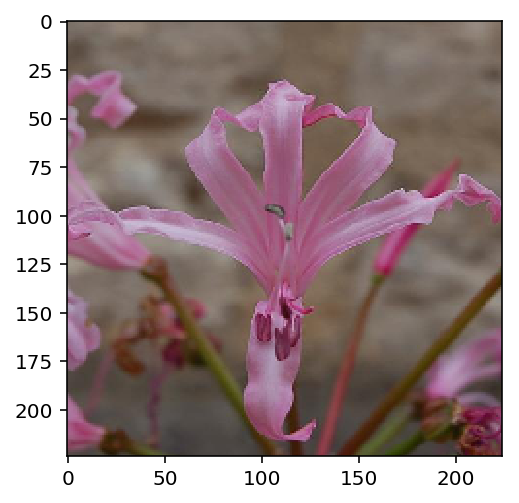

In [24]:
imshow(process_image('flowers/test/37/image_03789.jpg'))

In [25]:
 def predict(image_path, model, device, topk=5):
    
    # predict the class from an image file
    image = torch.from_numpy(process_image(image_path))
    image = image.unsqueeze(0).float()
    model, image = model.to(device), image.to(device)
    model.eval()
    model.requires_grad = False
    outputs = torch.exp(model.forward(image)).topk(topk)
    probs, classes = outputs[0].data.cpu().numpy()[0], outputs[1].data.cpu().numpy()[0]
    idx_to_class = {key: value for value, key in model.class_to_idx.items()}
    classes = [idx_to_class[classes[i]] for i in range(classes.size)]
    return probs, classes

image_path = 'flowers/test/37/image_03789.jpg'
probs, classes = predict(image_path, model, device)
print(probs)
print(classes)

[  9.99173522e-01   5.07382676e-04   1.69419582e-04   4.06927029e-05
   3.15469188e-05]
['37', '57', '88', '32', '94']


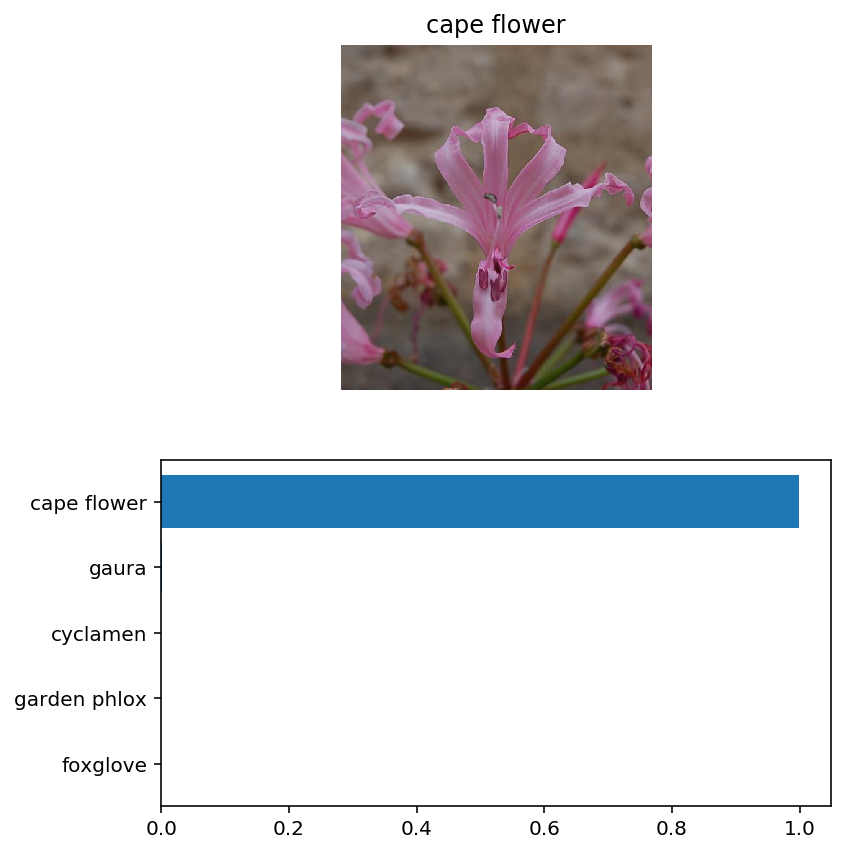

In [26]:
# Display image along with the top 5 classes
def view_classify(im, probs, classes, cat_to_name):
    name_classes = [cat_to_name[i] for i in classes]
    fig, (image_ax, graph_ax) = plt.subplots(figsize=(6,7), nrows=2)
    with Image.open(image_path) as img:
        image_ax.imshow(img)
    image_ax.axis('off')
    image_ax.set_title(cat_to_name[classes[0]])
    y_pos = np.arange(len(name_classes))
    graph_ax.barh(y_pos, probs)
    graph_ax.set_yticks(y_pos)
    graph_ax.set_yticklabels(name_classes)
    graph_ax.invert_yaxis()
    
view_classify(image_path, probs, classes, cat_to_name)